# Create Sites

This notebook creates a `sites.geojson` from the provided `plots.geojson`.

Every site has 5 plots, however, the site itself doesn't have a set boundary. In this notebook we create one by placing a buffer around the plots, merging plots of the same site, and defining the site geometry as the convex hull around those buffered plots. This site geometry is used for processing lidar data. The lidar processing can have some edge effects, so the buffer ensures those are not included in the plots.

This is the first step in the processing pipeline.

In [76]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

from pathlib import Path

In [77]:
data_dir = Path("../data")
plots_path = data_dir / "source" / "plots.geojson"

plots = gpd.read_file(plots_path)
plots.head(n=10)

site  plot_number                                           geometry
0  AGG_O_01            1  POLYGON ((463042.83 5259846.736, 463025.797 52...
1  AGG_O_01            2  POLYGON ((463124.556 5259819.234, 463116.068 5...
2  AGG_O_01            3  POLYGON ((463201.174 5259815.806, 463200.551 5...
3  AGG_O_01            4  POLYGON ((463257.777 5259801.962, 463245.303 5...
4  AGG_O_01            5  POLYGON ((463303.022 5259789.552, 463289.794 5...
5  AGG_O_05            1  POLYGON ((455349.836 5284229.271, 455311.381 5...
6  AGG_O_05            2  POLYGON ((455389.391 5284205.376, 455366.691 5...
7  AGG_O_05            3  POLYGON ((455433.991 5284190.707, 455417.943 5...
8  AGG_O_05            4  POLYGON ((455259.572 5284171.279, 455237.31 52...
9  AGG_O_05            5  POLYGON ((455206.927 5284158.649, 455195.902 5...

In [78]:
buffer_amount = 10

# Make a copy of the plots GeoDataFrame
plots_copy = plots.copy()

# Merge plots of the same site together
sites_dissolved = plots_copy.dissolve(by="site", as_index=False)

# Create a convex hull around the dissolved geometries to ensure a single polygon
sites_dissolved["geometry"] = sites_dissolved.geometry.convex_hull

# Add a 10m buffer
sites_dissolved["geometry"] = sites_dissolved['geometry'].buffer(buffer_amount, cap_style="square", join_style="mitre")

# Select only the necessary columns
sites = sites_dissolved[["site", "geometry"]]

# Copy the site field into id as well
sites["id"] = sites["site"]

sites.head(n=10)

site                                           geometry        id
0  AGG_O_01  POLYGON ((463297.055 5259730.003, 463114.406 5...  AGG_O_01
1  AGG_O_05  POLYGON ((455424.932 5284132.819, 455198.808 5...  AGG_O_05
2  AGG_O_07  POLYGON ((464763.357 5299168.26, 464710.087 52...  AGG_O_07
3  AGG_Y_02  POLYGON ((491861.764 5230973.15, 491841.78 523...  AGG_Y_02
4  AGG_Y_03  POLYGON ((490742.665 5208817.085, 490681.529 5...  AGG_Y_03
5  AGG_Y_04  POLYGON ((478371.012 5242343.425, 478364.203 5...  AGG_Y_04
6  EPO_O_04  POLYGON ((474703.208 5272114.355, 474546.84 52...  EPO_O_04
7  EPO_O_13  POLYGON ((489899.32 5257333.816, 489844.628 52...  EPO_O_13
8  EPO_Y_10  POLYGON ((462284.004 5259972.08, 462252.119 52...  EPO_Y_10
9  EPO_Y_15  POLYGON ((456680.006 5299130.513, 456632.167 5...  EPO_Y_15

## Missing sites

There a couple of sites we don't have data for, or the data is incomplete. We will remove them here. This step needs to be removed when the sites are available. The missing sites are:
- ULY_O_27
- ULO_212
- ULY_Y_01

In [79]:
sites = sites.query("site not in ['ULY_O_27', 'ULO_212', 'ULY_Y_01']")

In [80]:
# Save sites to a GeoJSON file
output_dir = data_dir / "outputs" / "sites"
output_dir.mkdir(parents=True, exist_ok=True)
output_path = output_dir / "sites.geojson"
sites.to_file(output_path, driver="GeoJSON")

We'll remove the relevant plots and create a plot id field and save that out too

In [81]:
plots["site_plot_id"] = plots["site"] + "_P" + plots["plot_number"].astype('str')
plots["id"] = plots["site_plot_id"]
plots = plots.query("site not in ['ULY_O_27', 'ULO_212', 'ULY_Y_01']")
plots

site  plot_number                                           geometry  \
0    AGG_O_01            1  POLYGON ((463042.83 5259846.736, 463025.797 52...   
1    AGG_O_01            2  POLYGON ((463124.556 5259819.234, 463116.068 5...   
2    AGG_O_01            3  POLYGON ((463201.174 5259815.806, 463200.551 5...   
3    AGG_O_01            4  POLYGON ((463257.777 5259801.962, 463245.303 5...   
4    AGG_O_01            5  POLYGON ((463303.022 5259789.552, 463289.794 5...   
..        ...          ...                                                ...   
325  ULY_Y_96            1  POLYGON ((455348.476 5275834.517, 455348.154 5...   
326  ULY_Y_96            2  POLYGON ((455296.576 5275837.224, 455299.223 5...   
327  ULY_Y_96            3  POLYGON ((455252.092 5275834.16, 455248.849 52...   
328  ULY_Y_96            4  POLYGON ((455260.873 5275804.177, 455212.771 5...   
329  ULY_Y_96            5  POLYGON ((455248.927 5275757.266, 455200.476 5...   

    site_plot_id           id  
0    AGG_O_01_P1  AGG_O_01_P1  
1    AGG_O_01_P2  AGG_O_01_P2  
2    AGG_O_01_P3  AGG_O_01_P3  
3    AGG_O_01_P4  AGG_O_01_P4  
4    AGG_O_01_P5  AGG_O_01_P5  
..           ...          ...  
325  ULY_Y_96_P1  ULY_Y_96_P1  
326  ULY_Y_96_P2  ULY_Y_96_P2  
327  ULY_Y_96_P3  ULY_Y_96_P3  
328  ULY_Y_96_P4  ULY_Y_96_P4  
329  ULY_Y_96_P5  ULY_Y_96_P5  

[315 rows x 5 columns]

In [82]:
# Save plots to a GeoJSON file
output_dir = data_dir / "outputs" / "plots"
output_dir.mkdir(parents=True, exist_ok=True)
output_path = output_dir / "plots.geojson"
plots.to_file(output_path, driver="GeoJSON")

## Visualising sites and plots

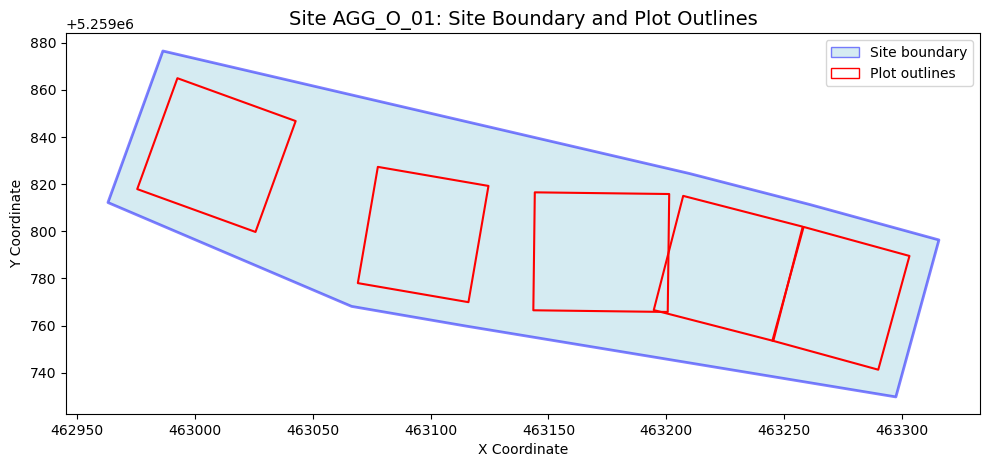

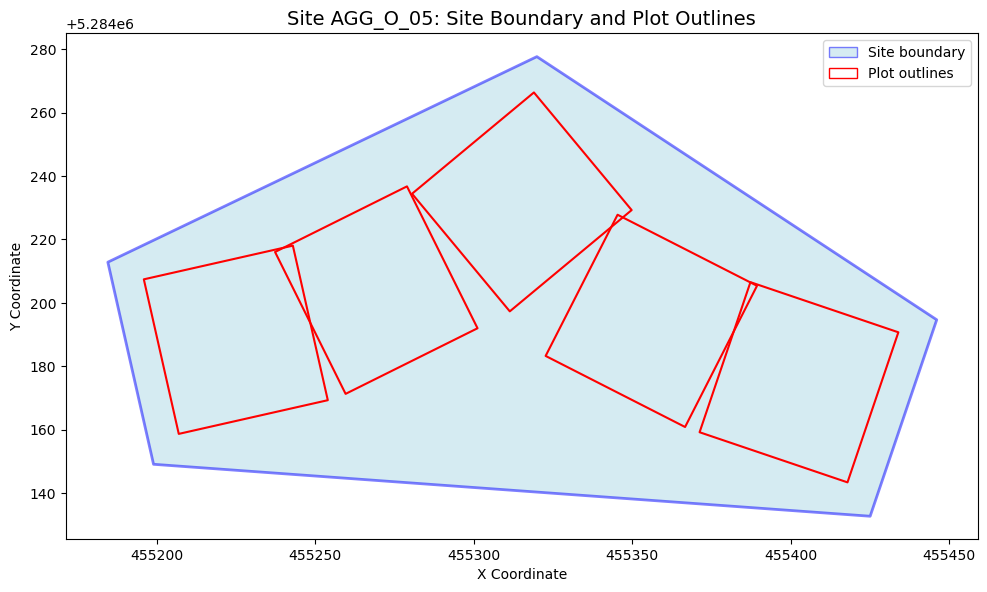

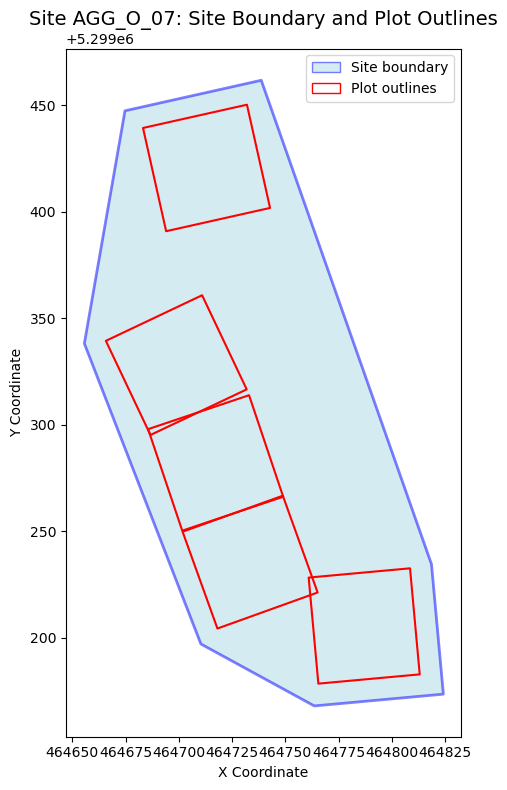

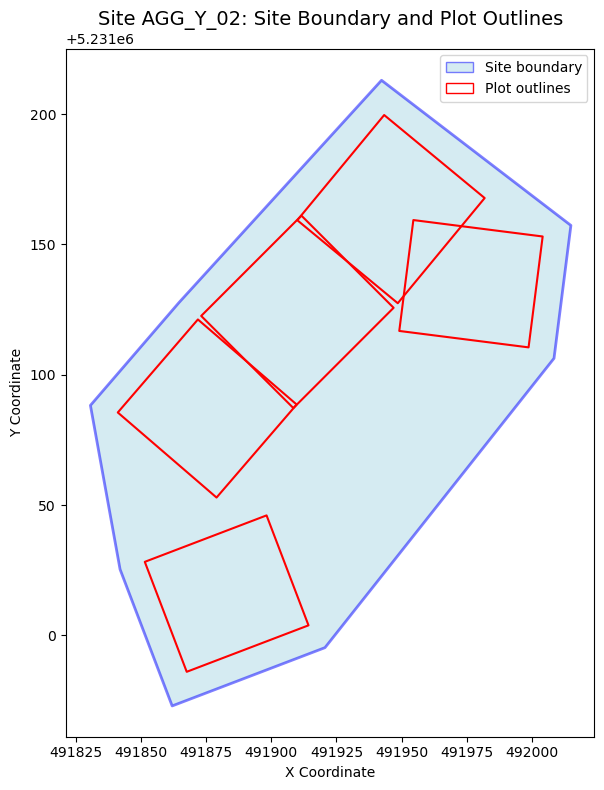

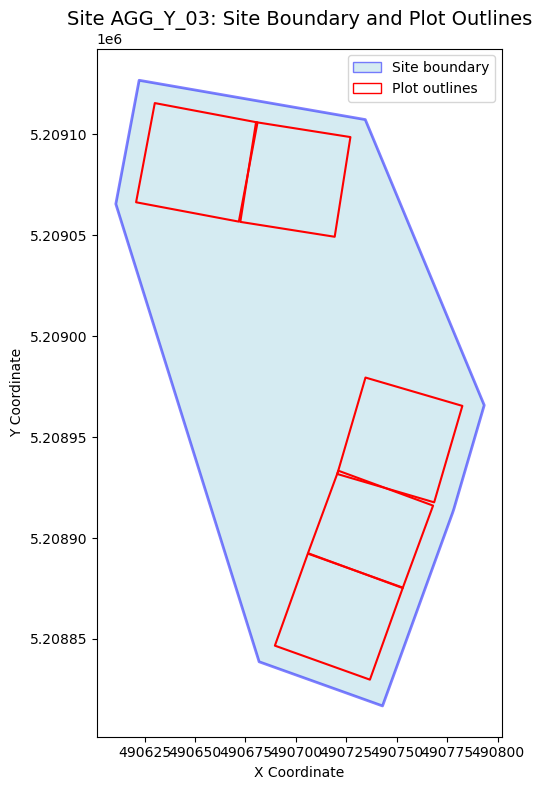

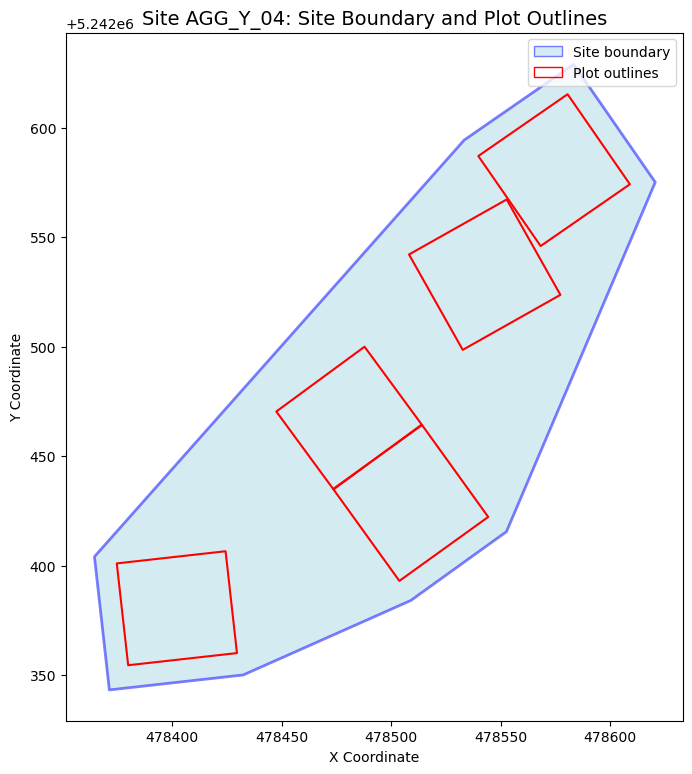

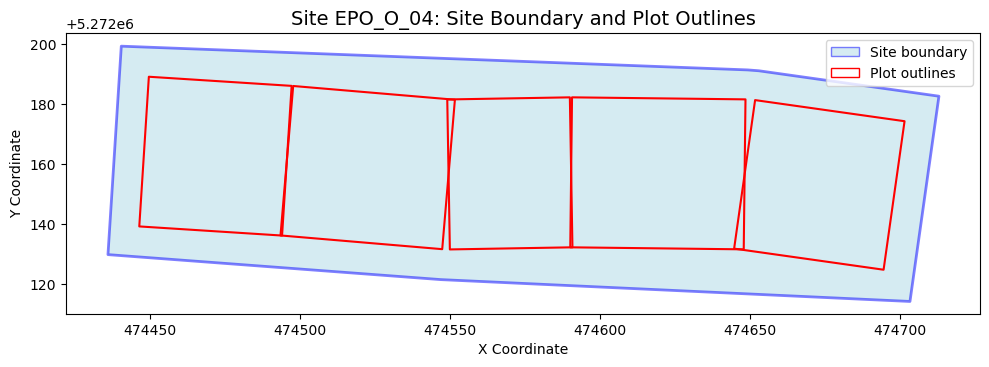

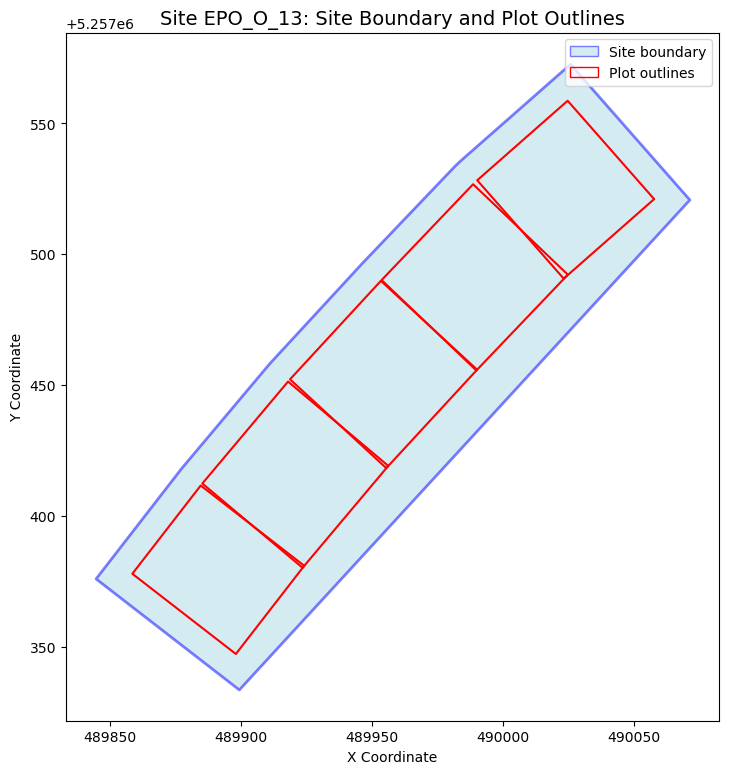

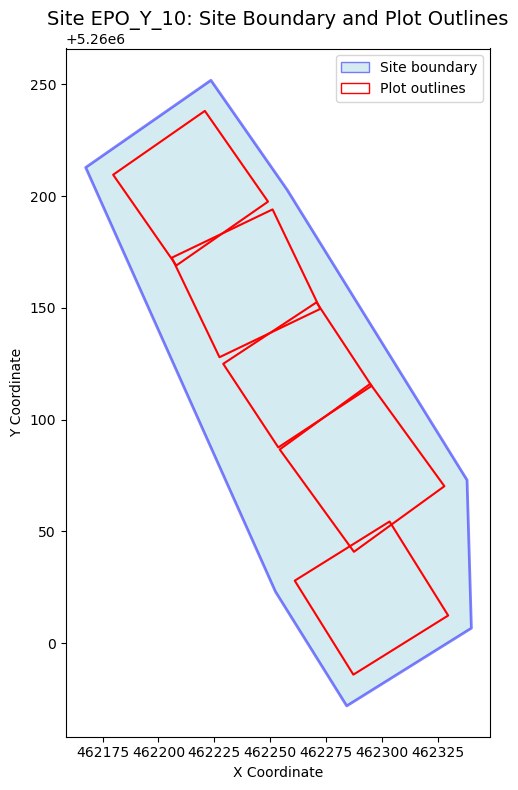

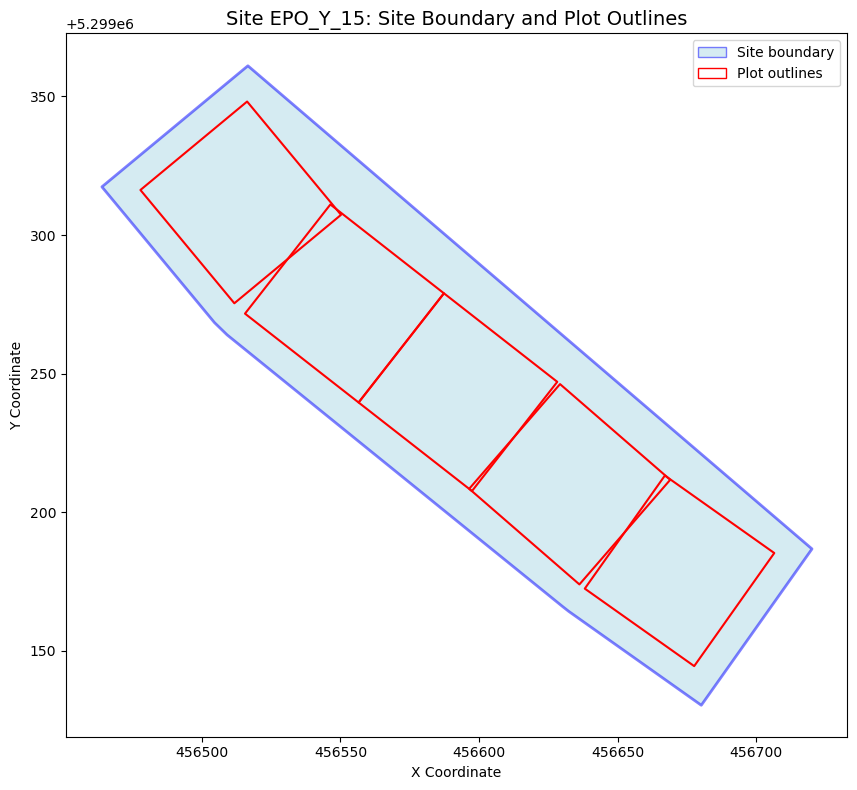

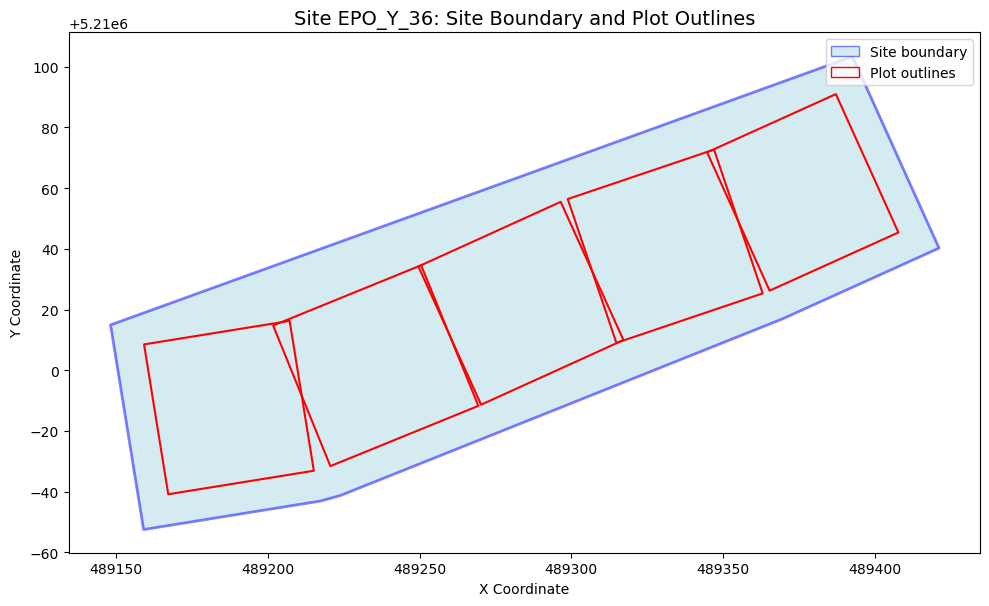

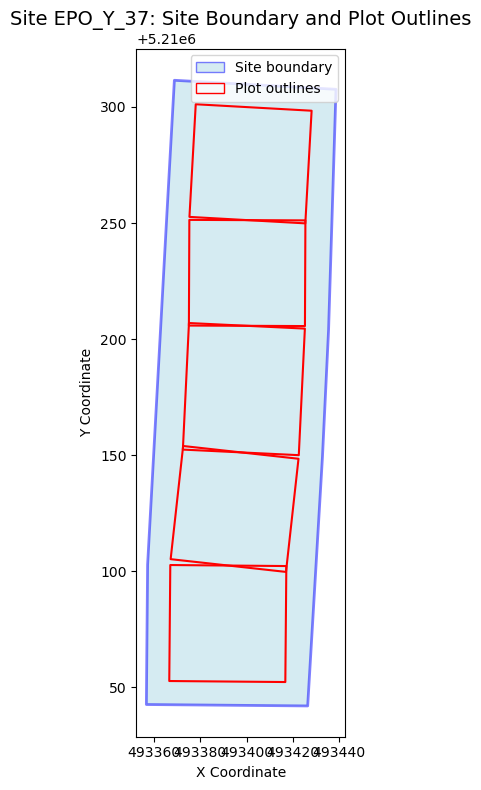

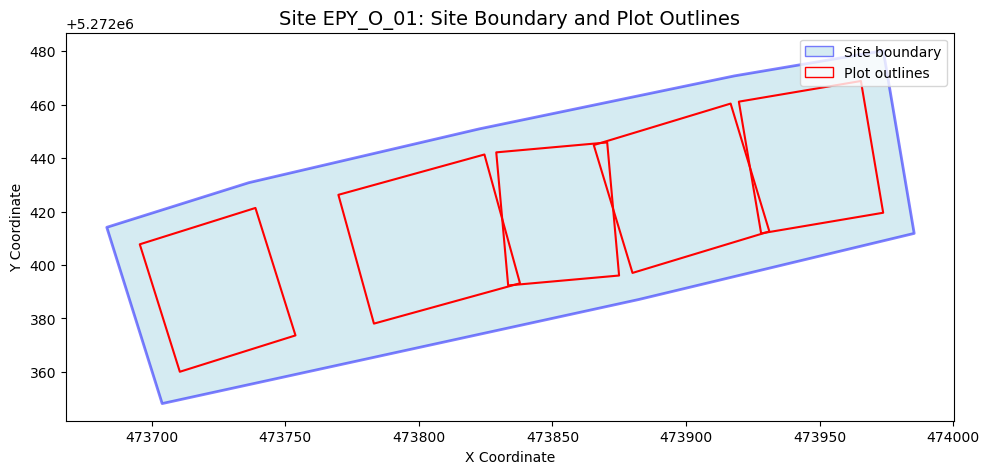

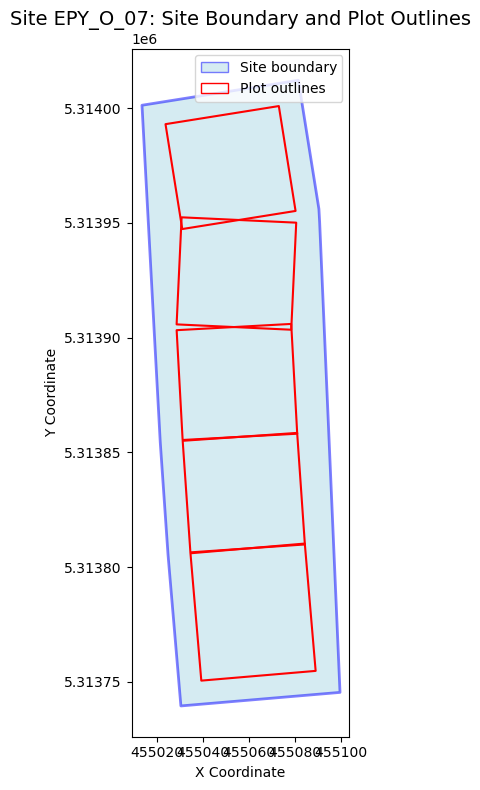

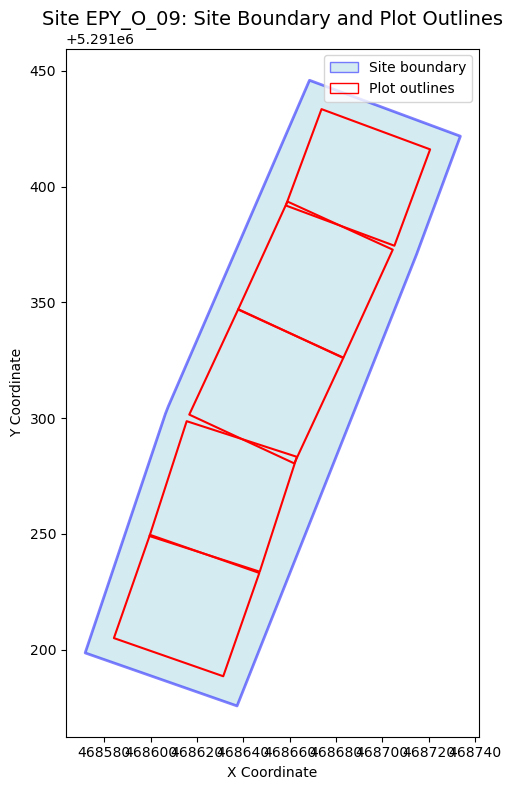

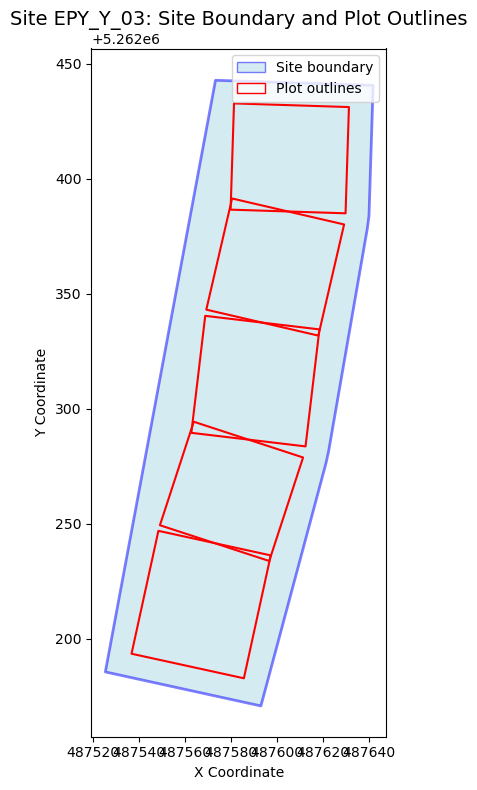

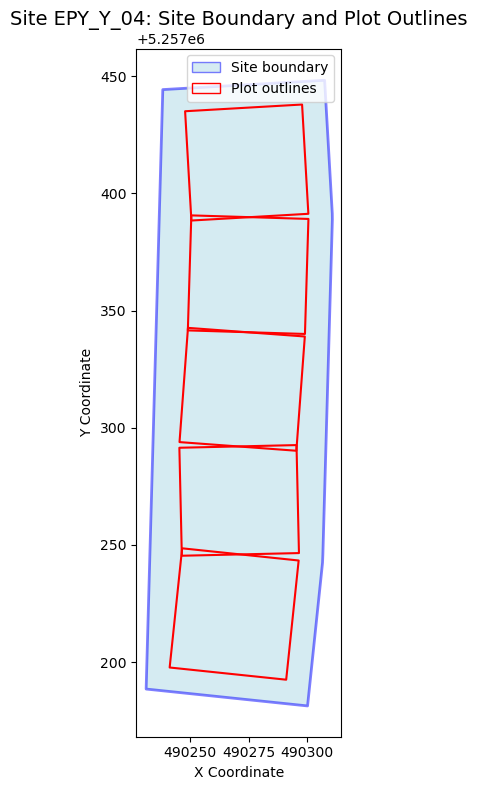

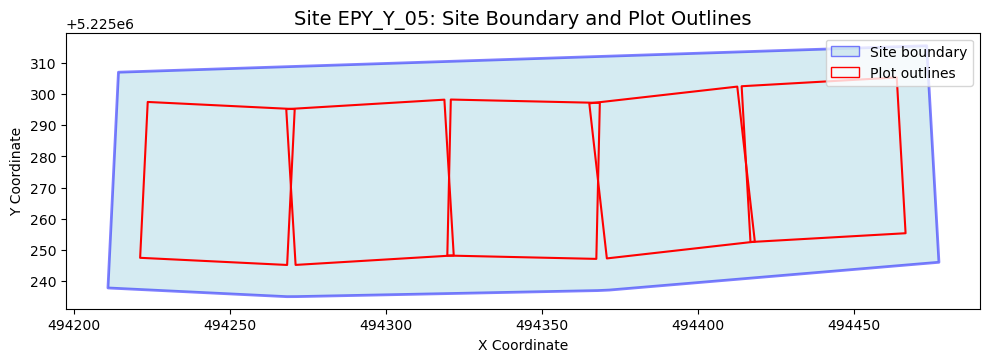

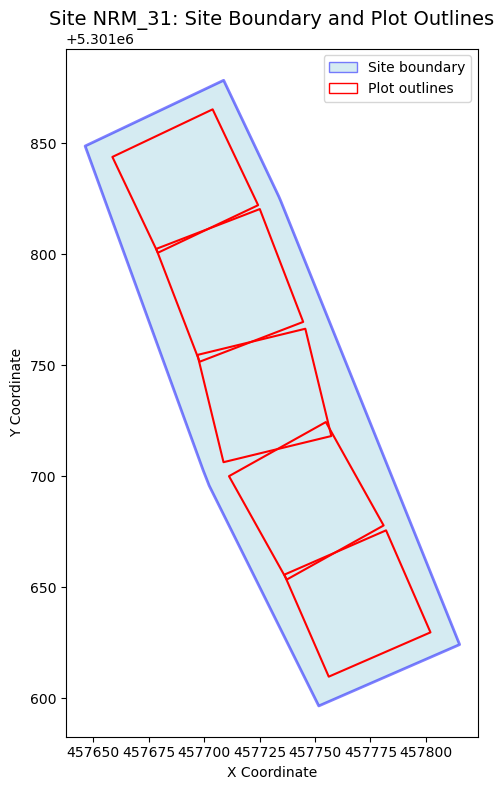

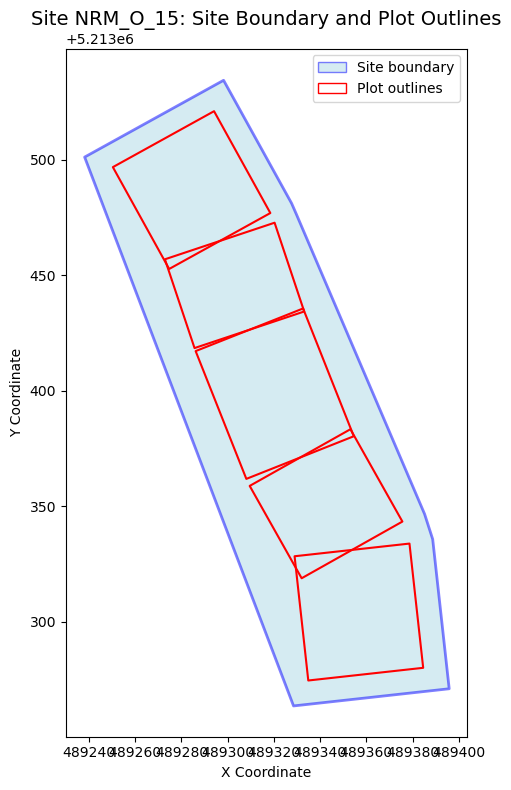

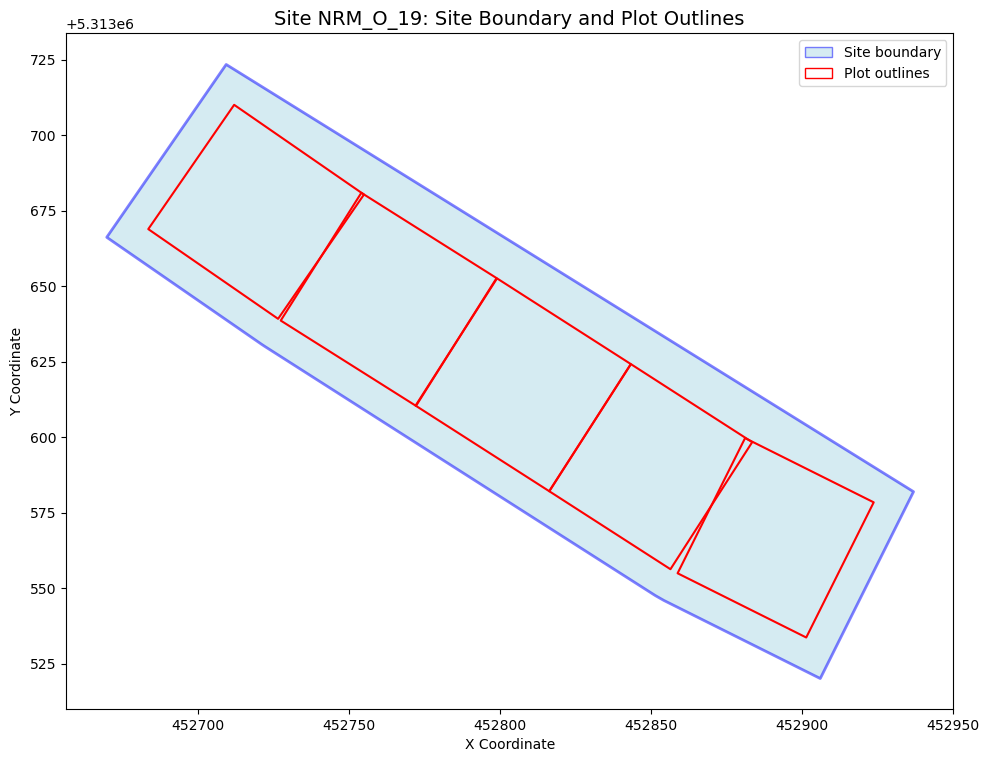

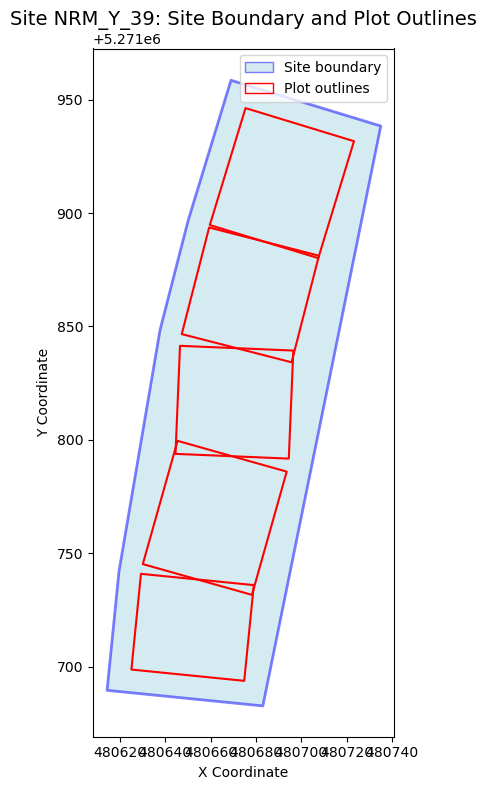

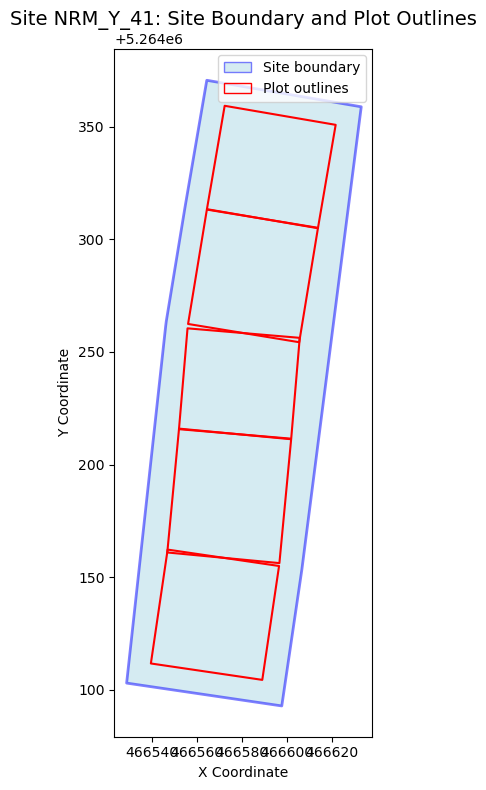

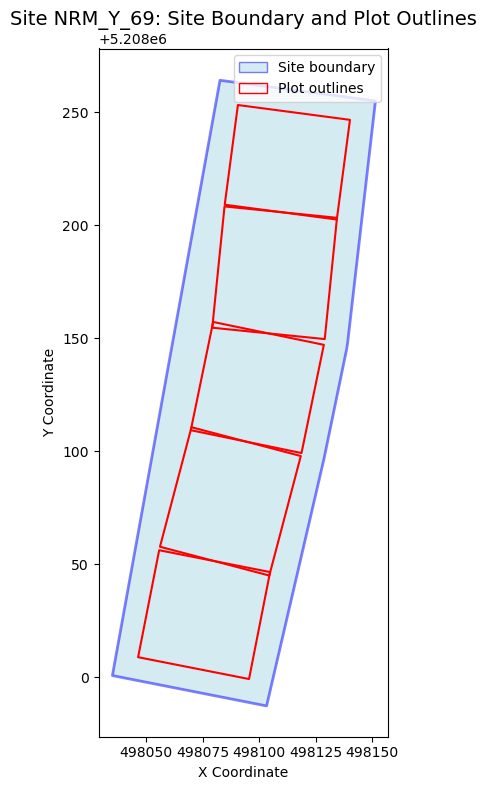

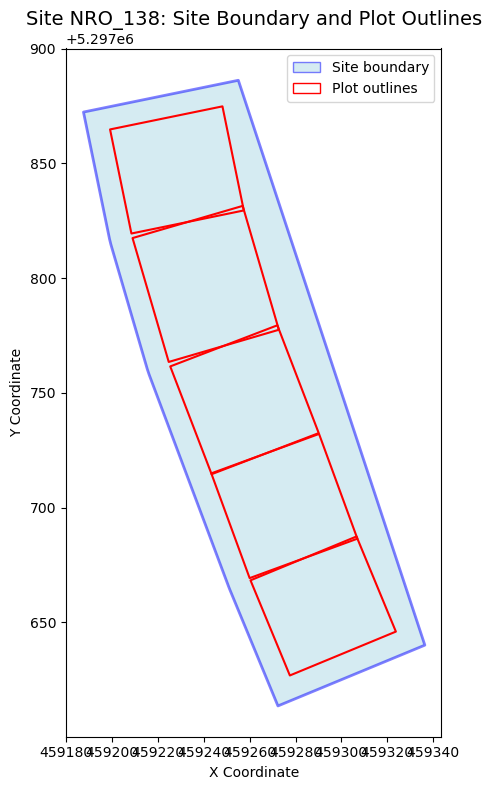

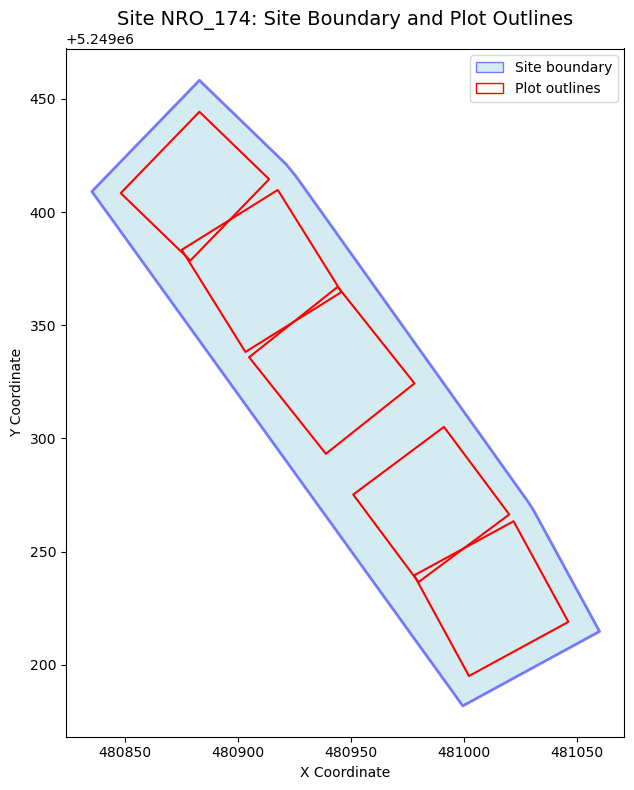

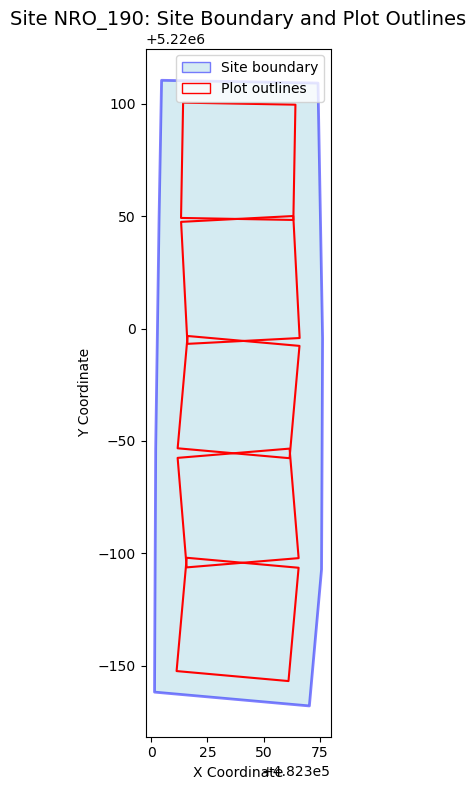

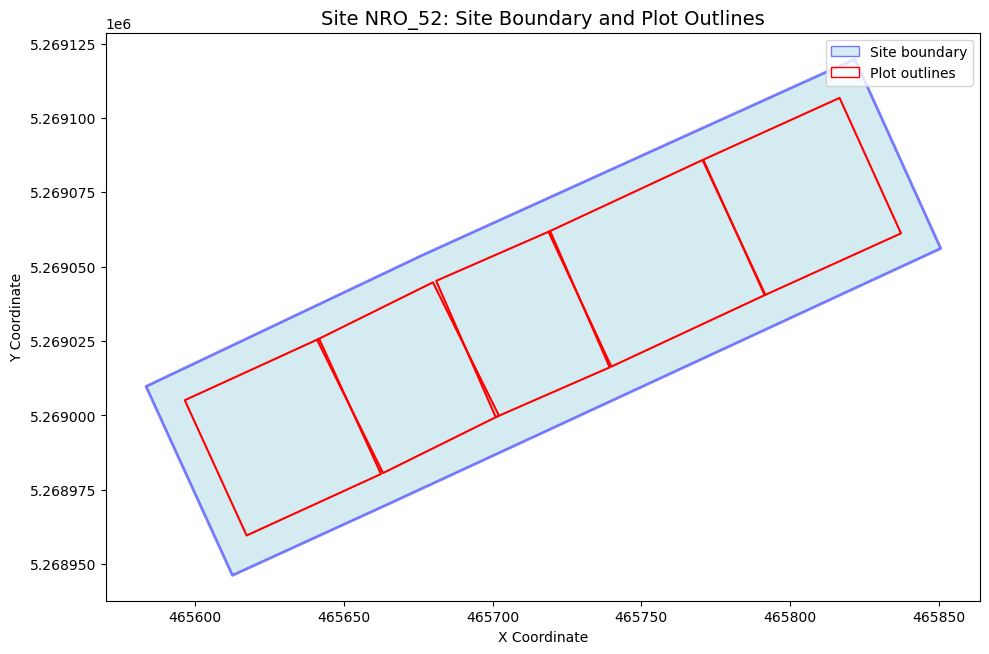

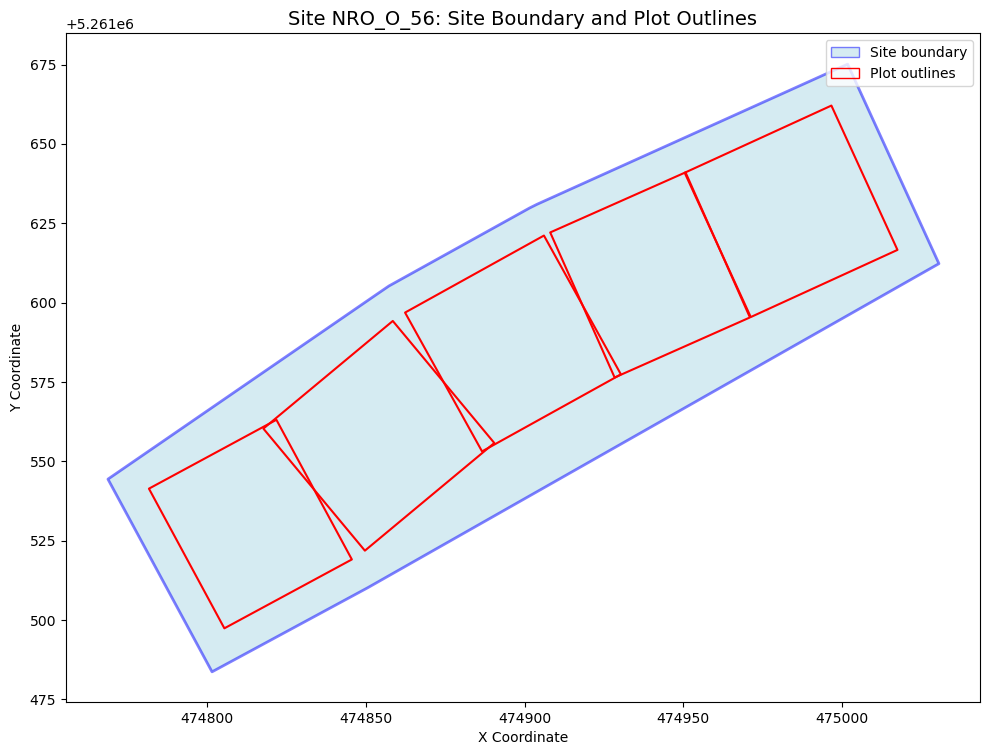

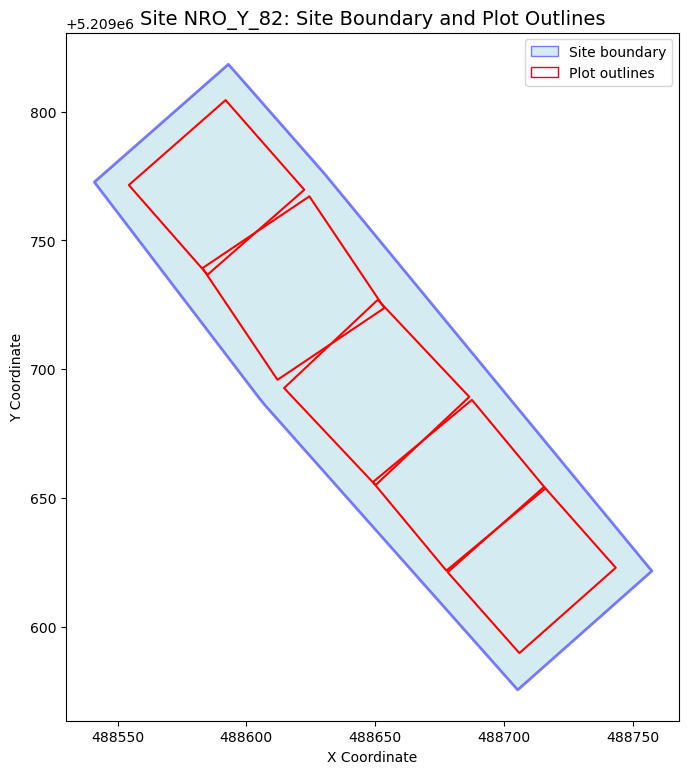

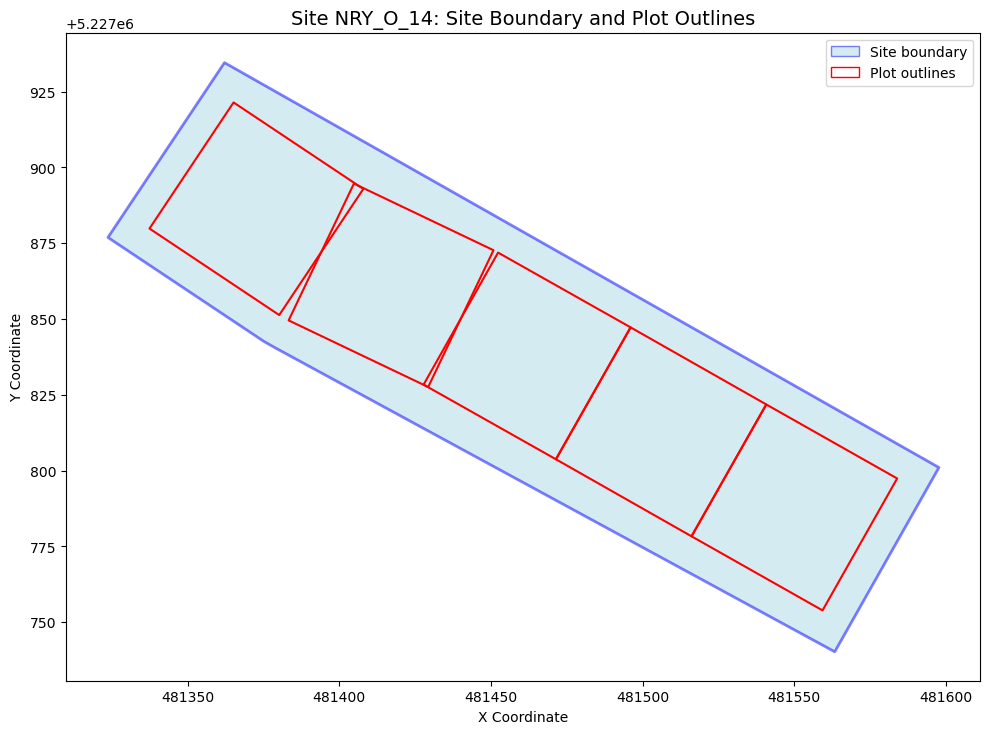

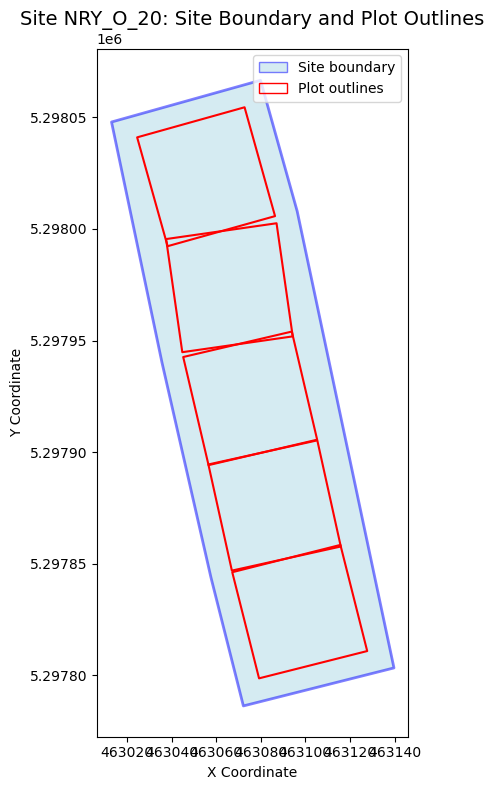

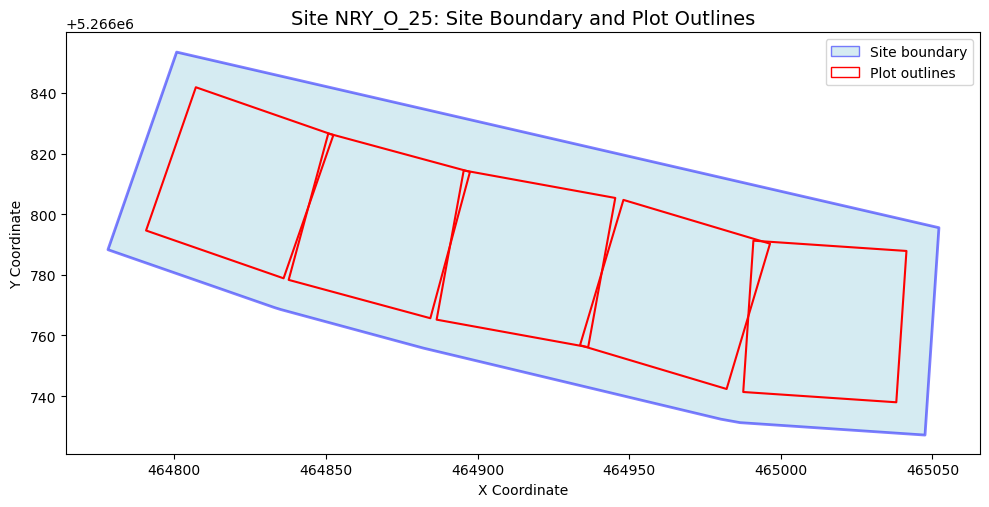

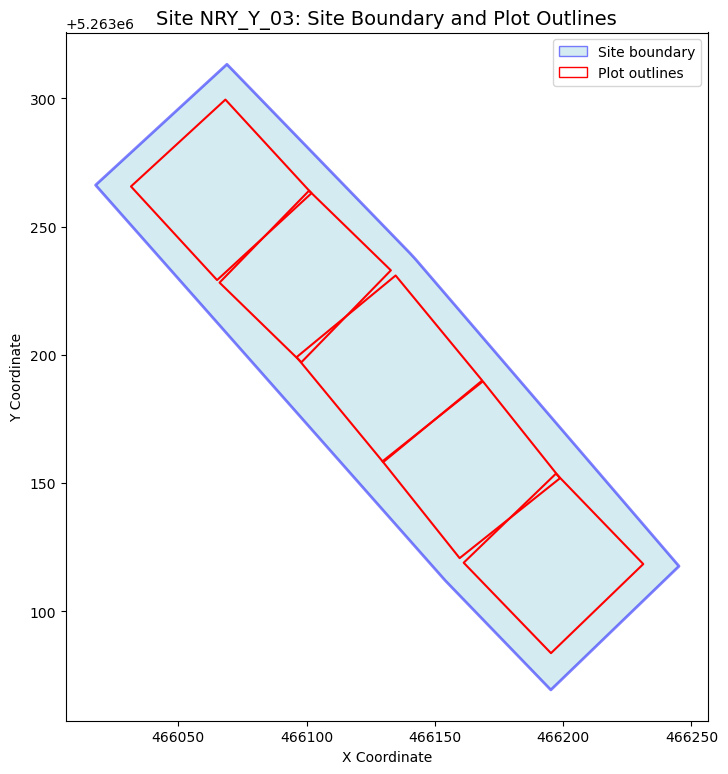

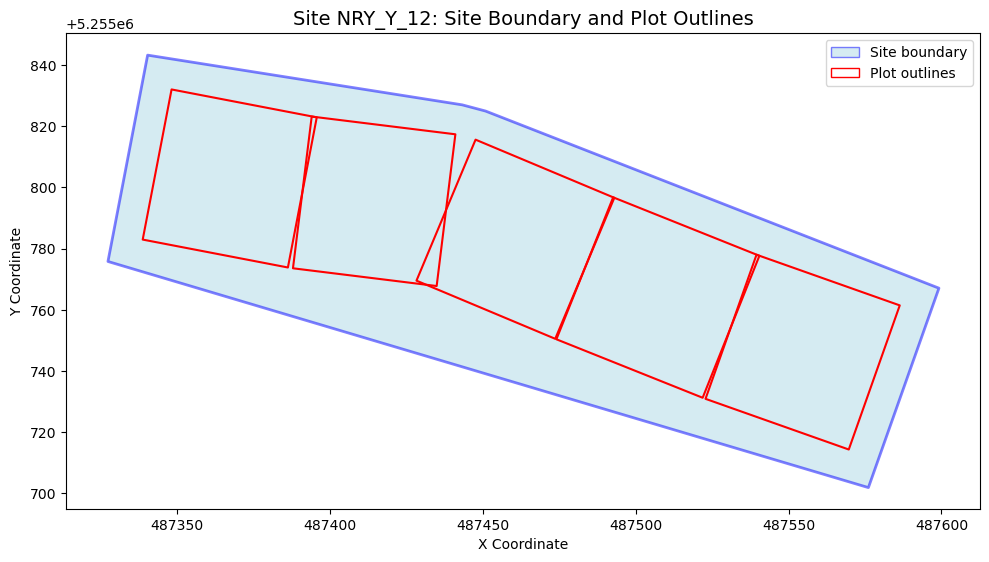

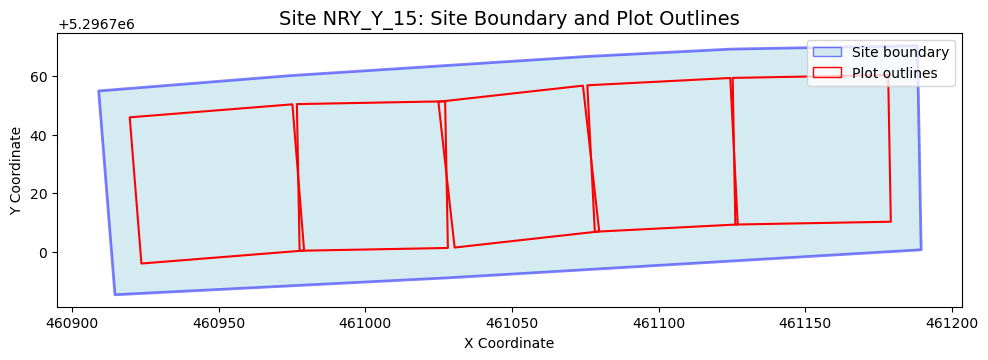

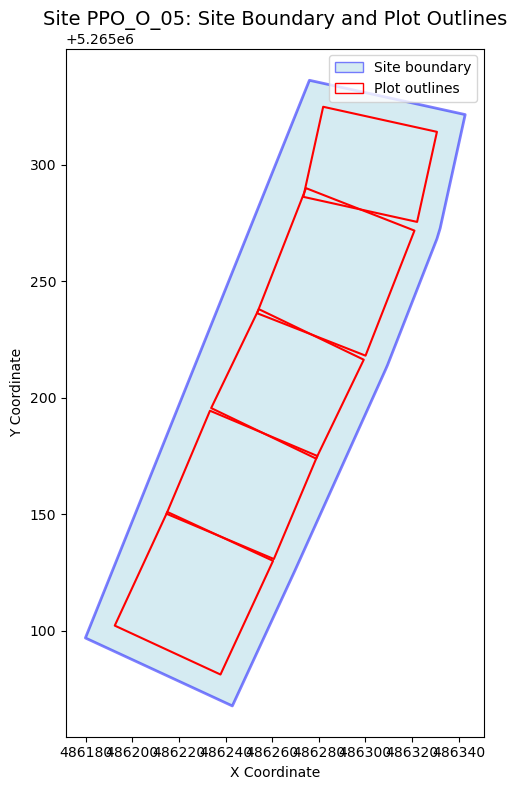

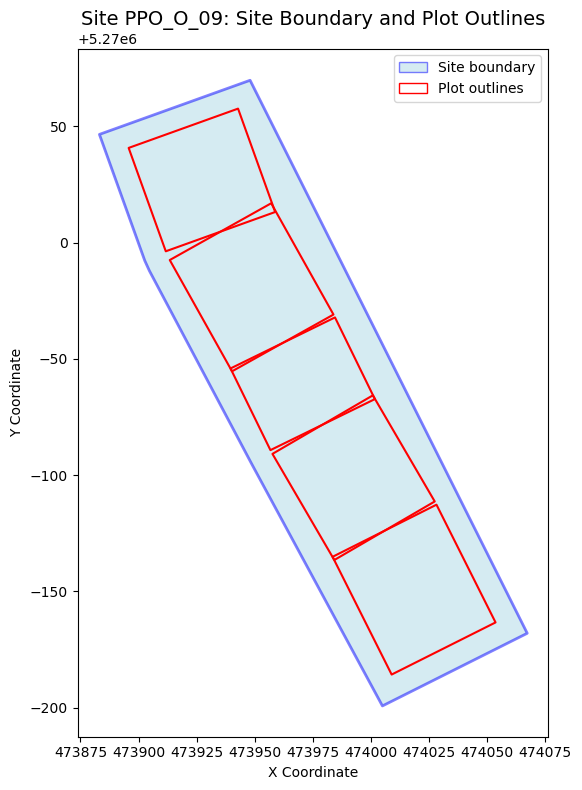

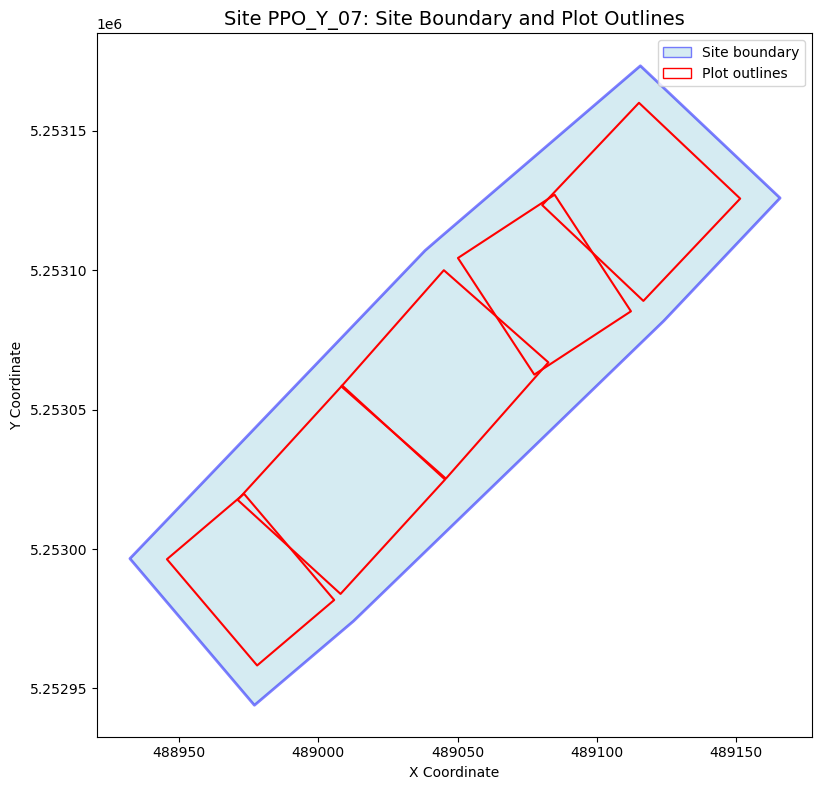

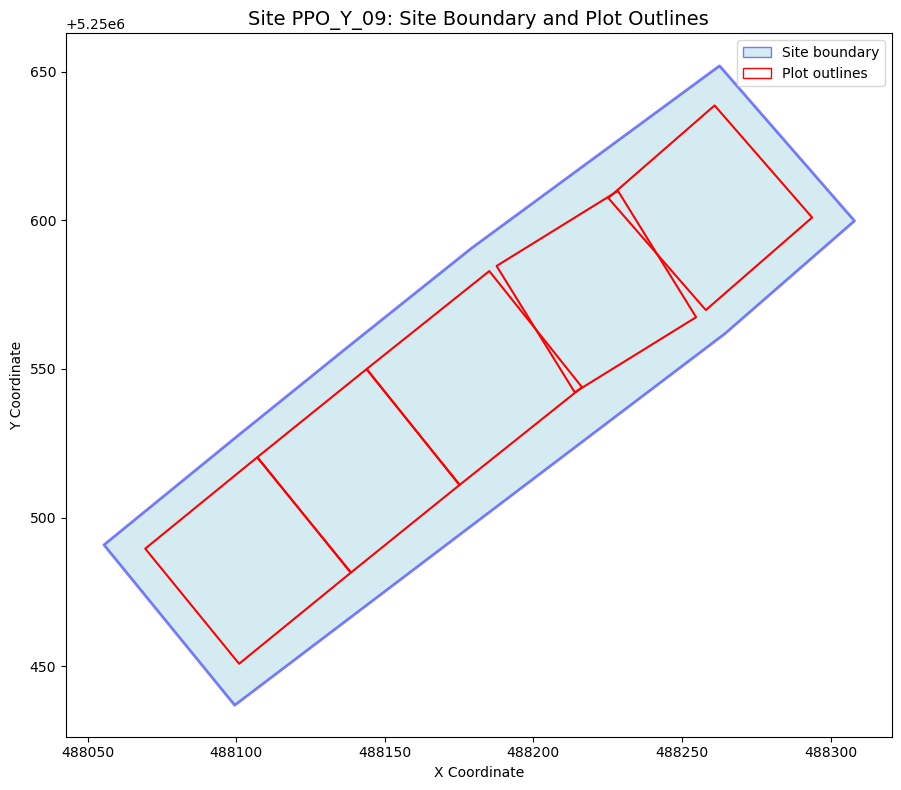

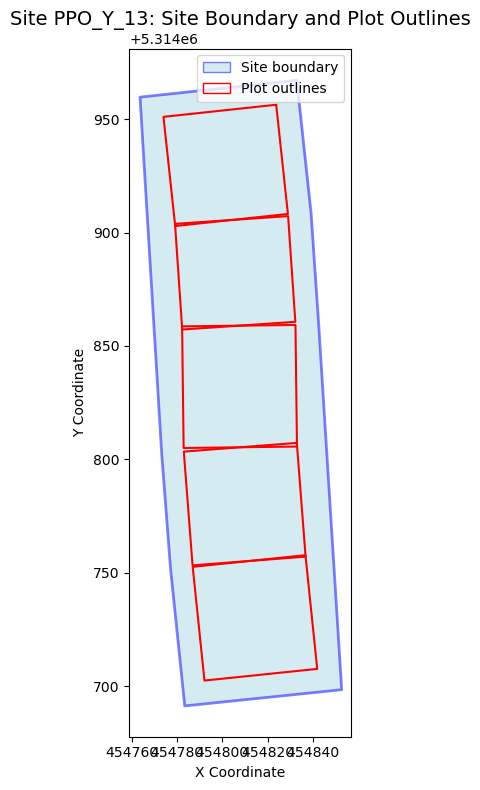

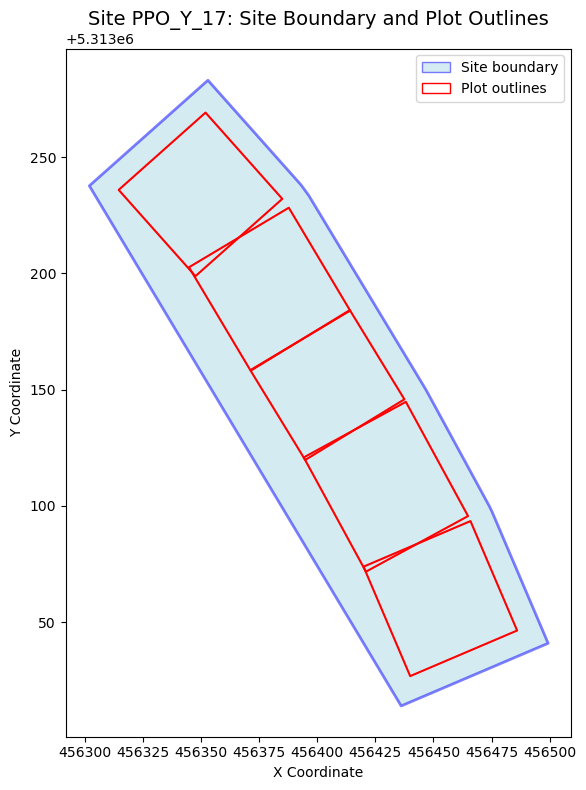

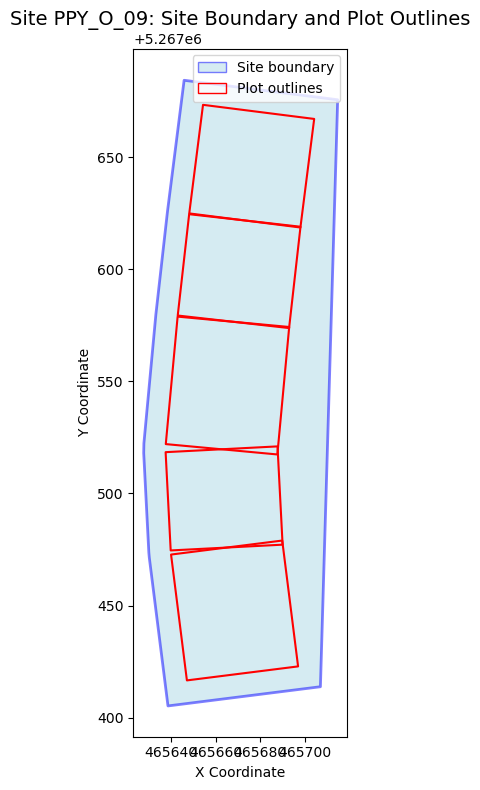

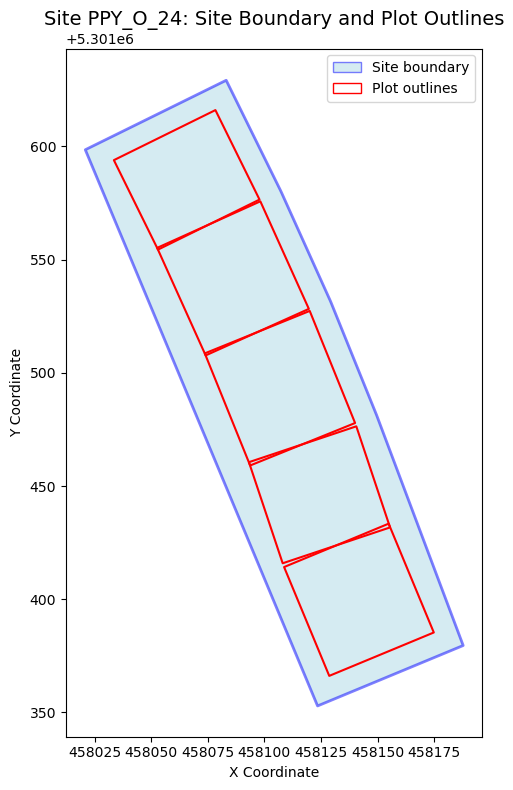

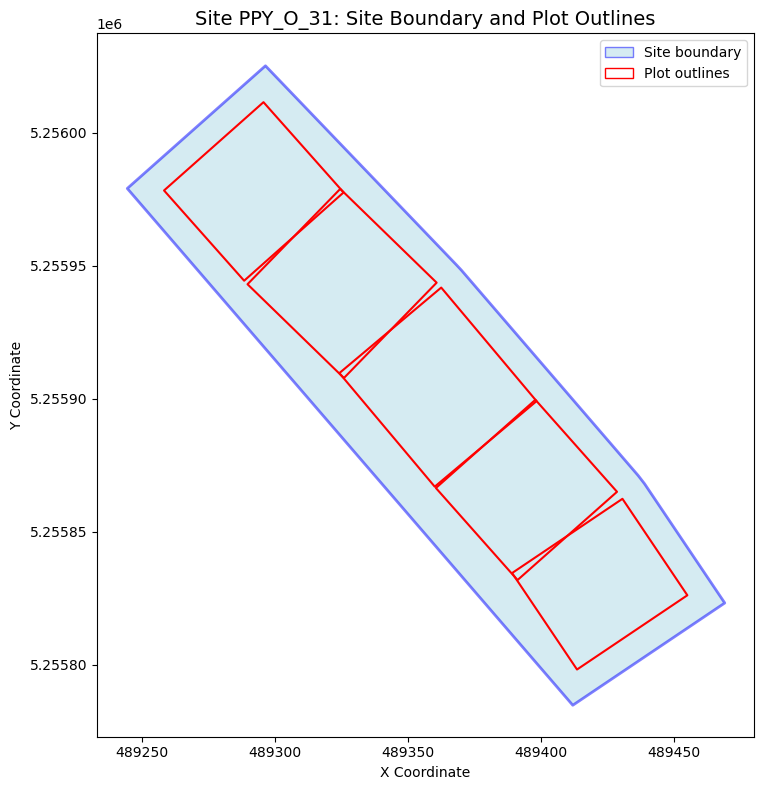

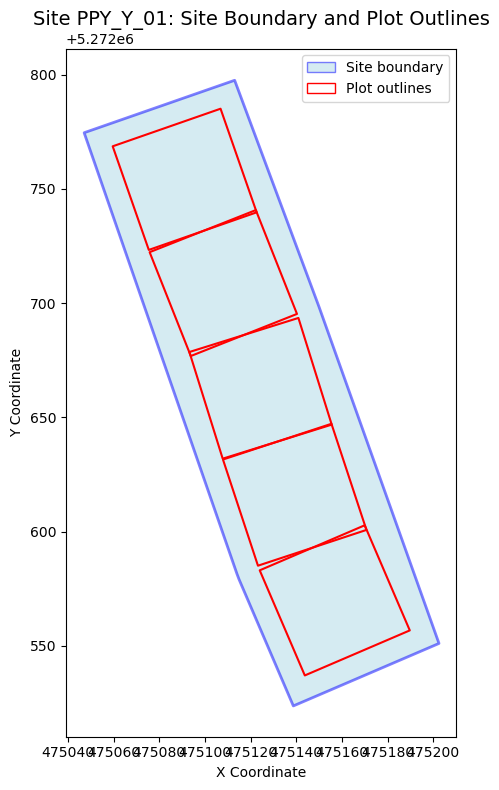

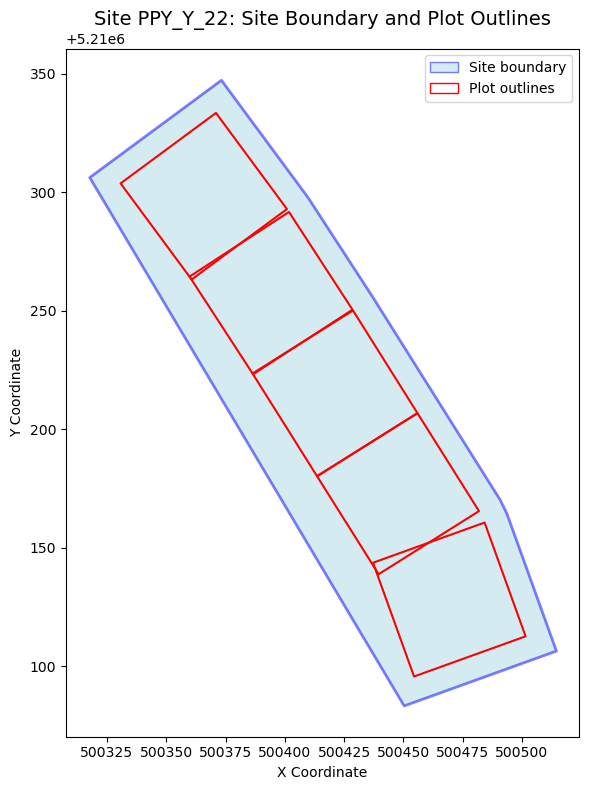

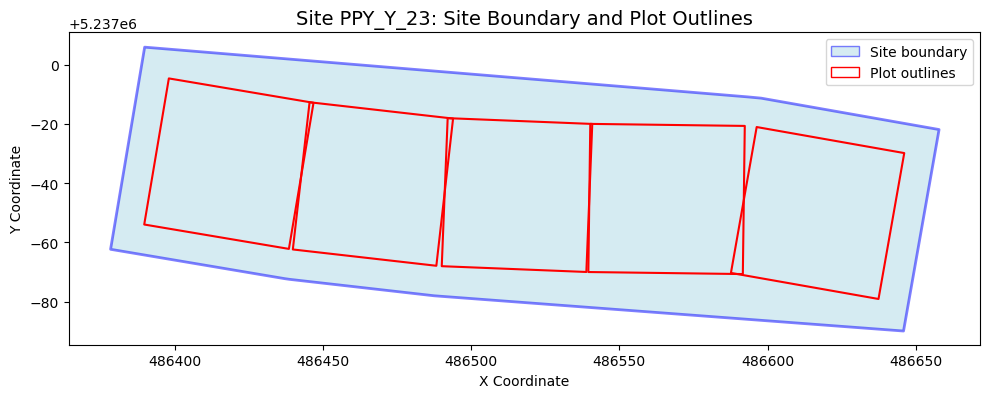

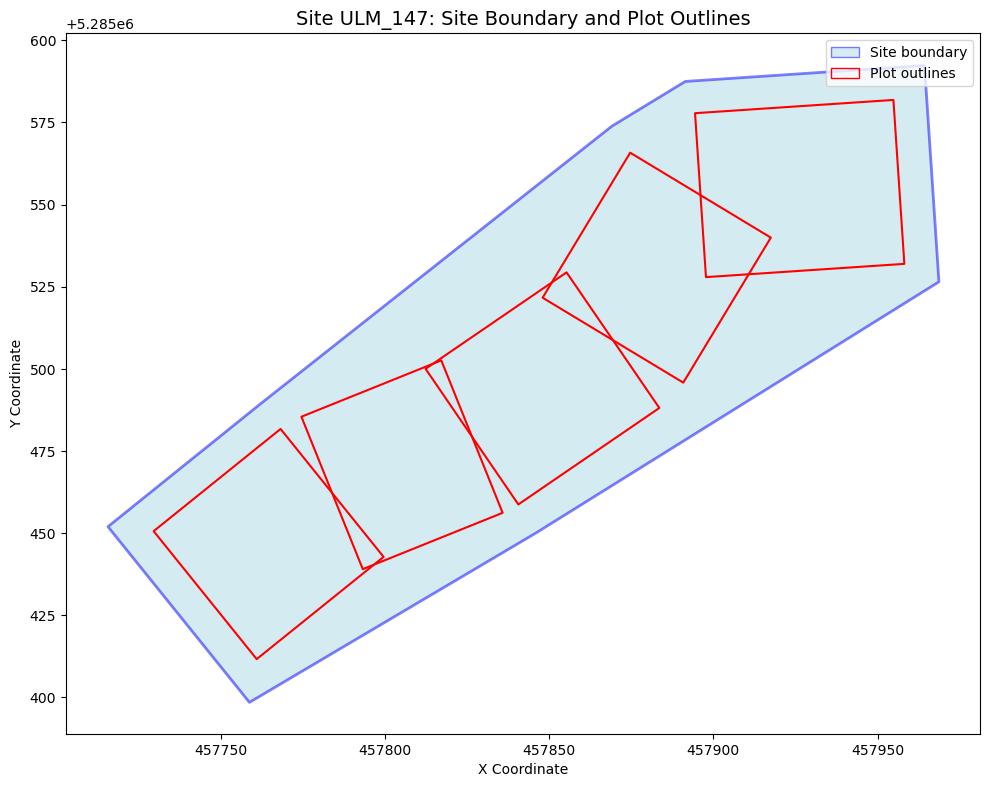

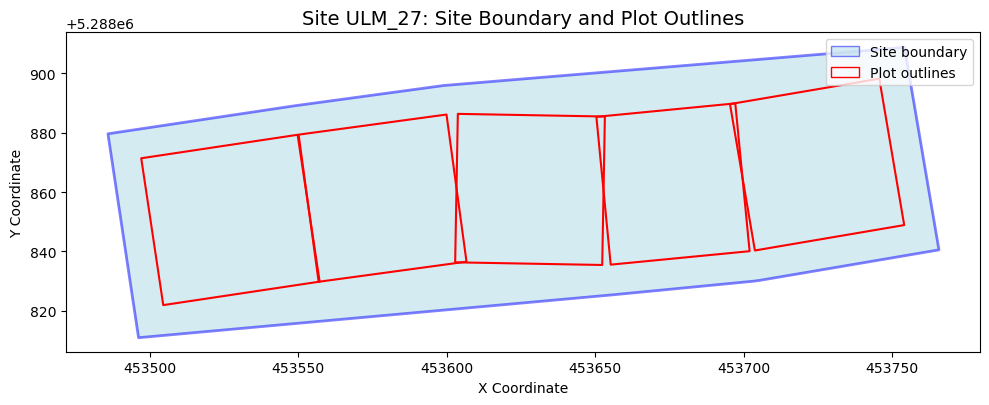

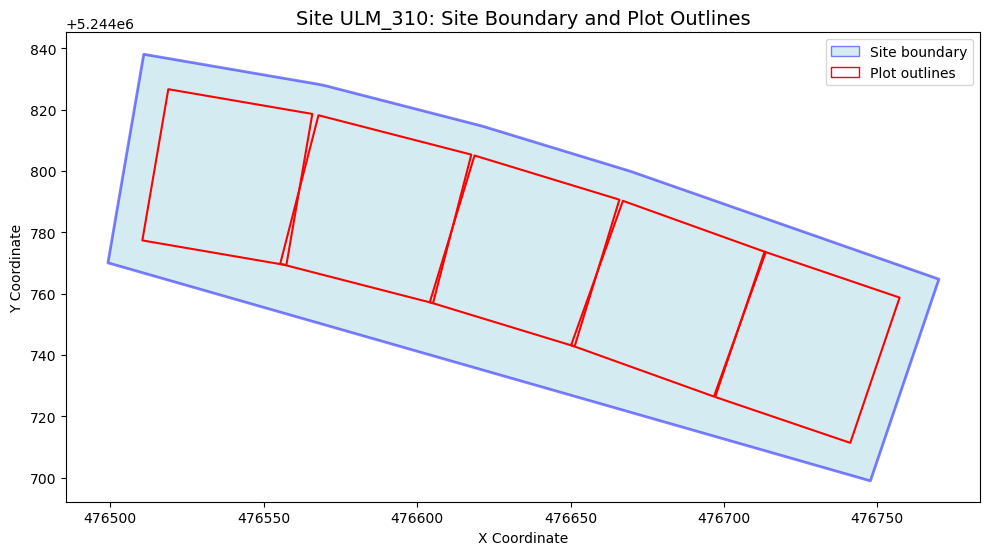

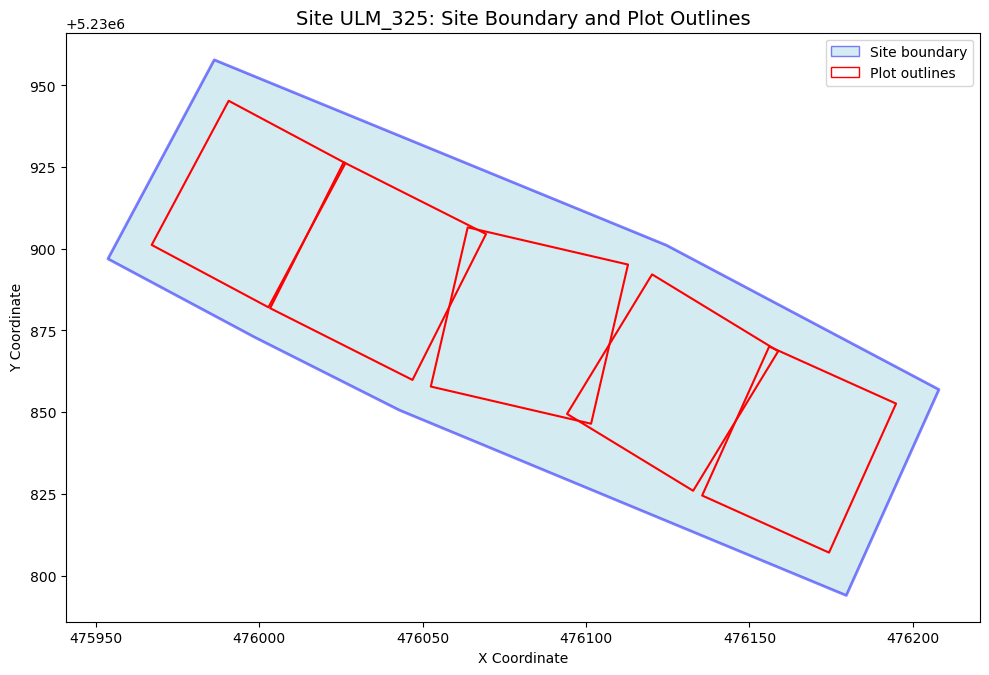

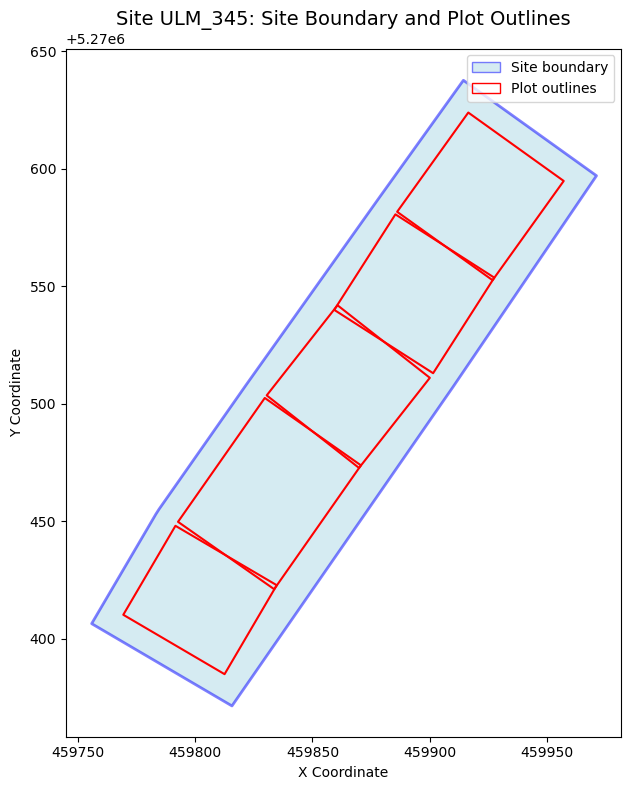

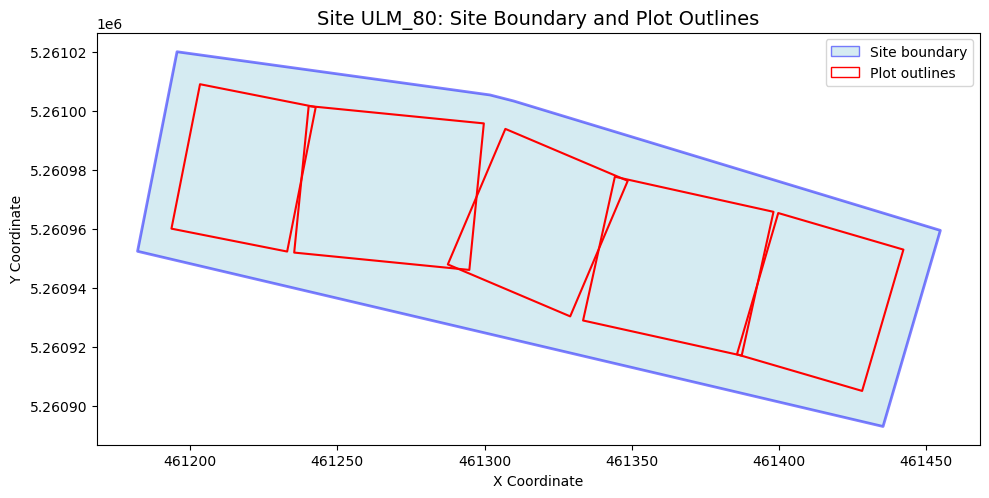

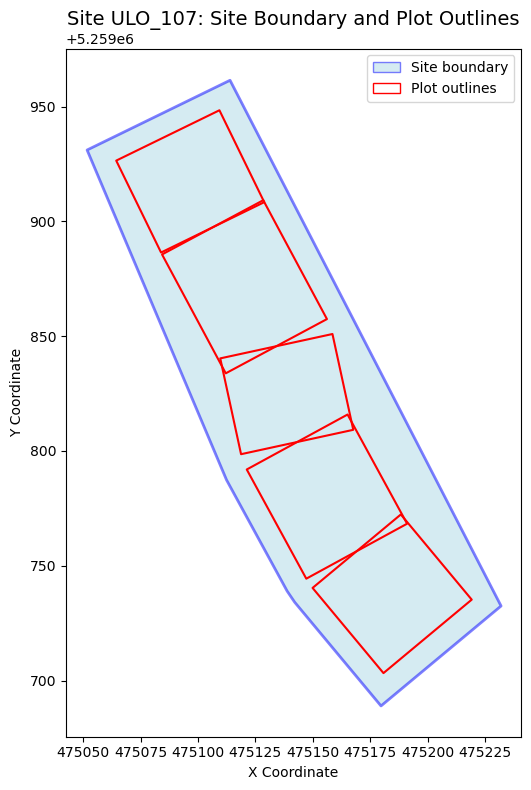

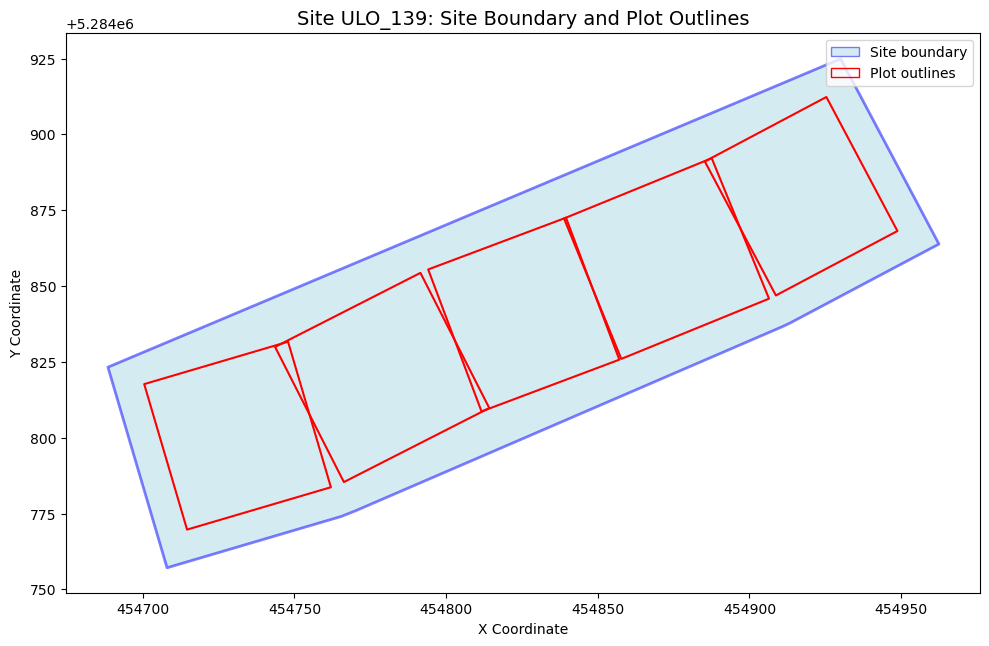

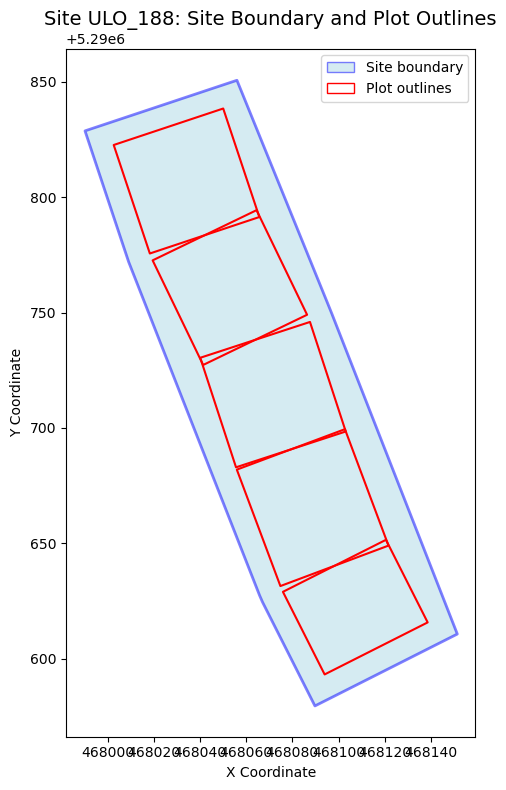

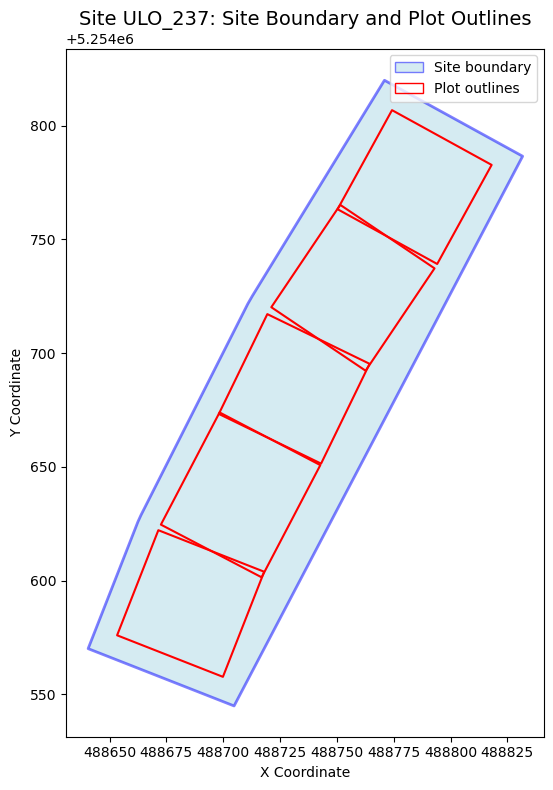

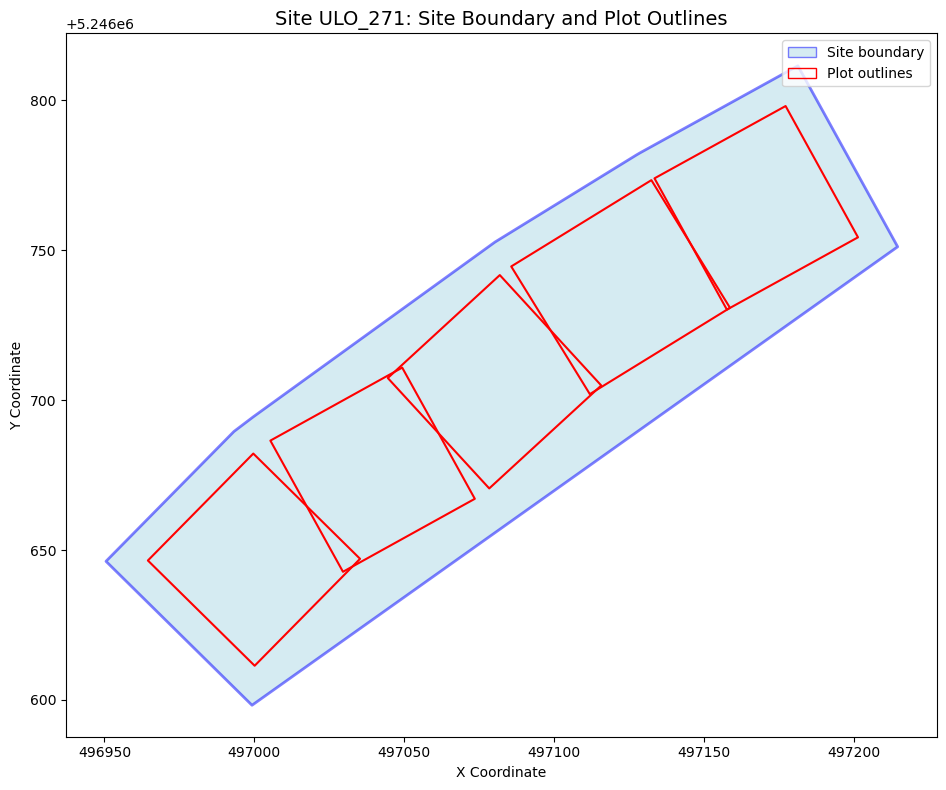

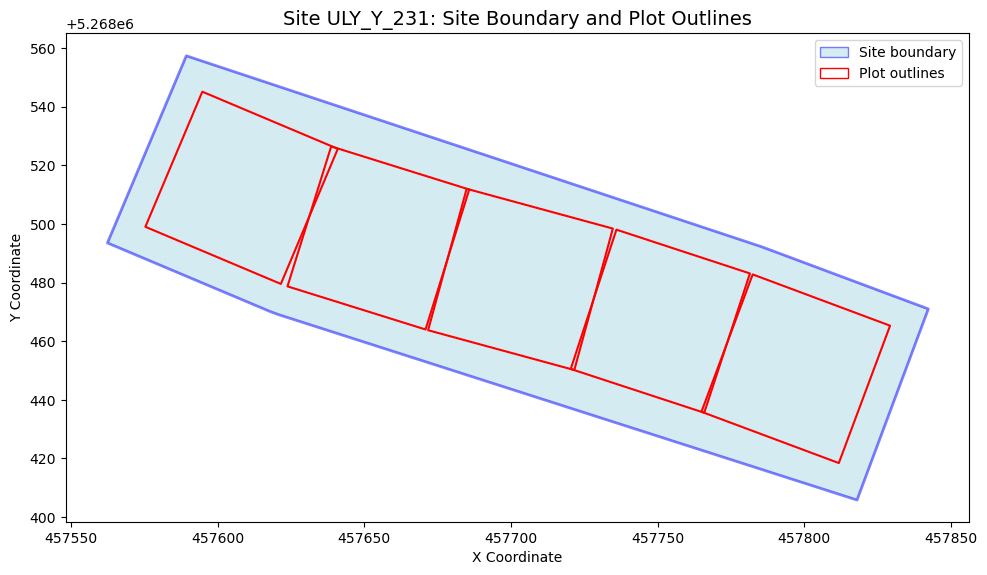

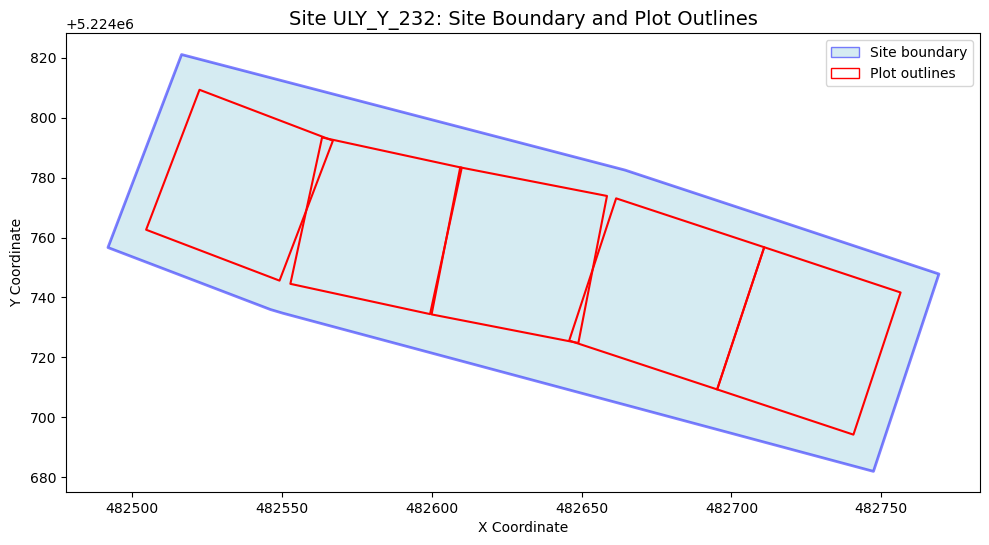

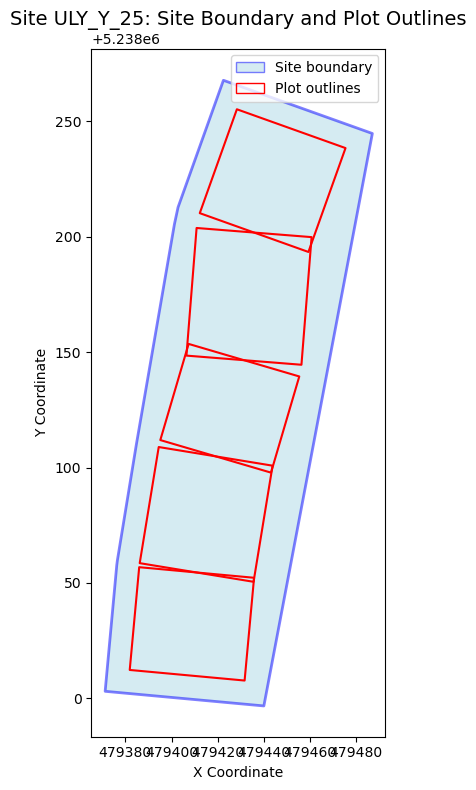

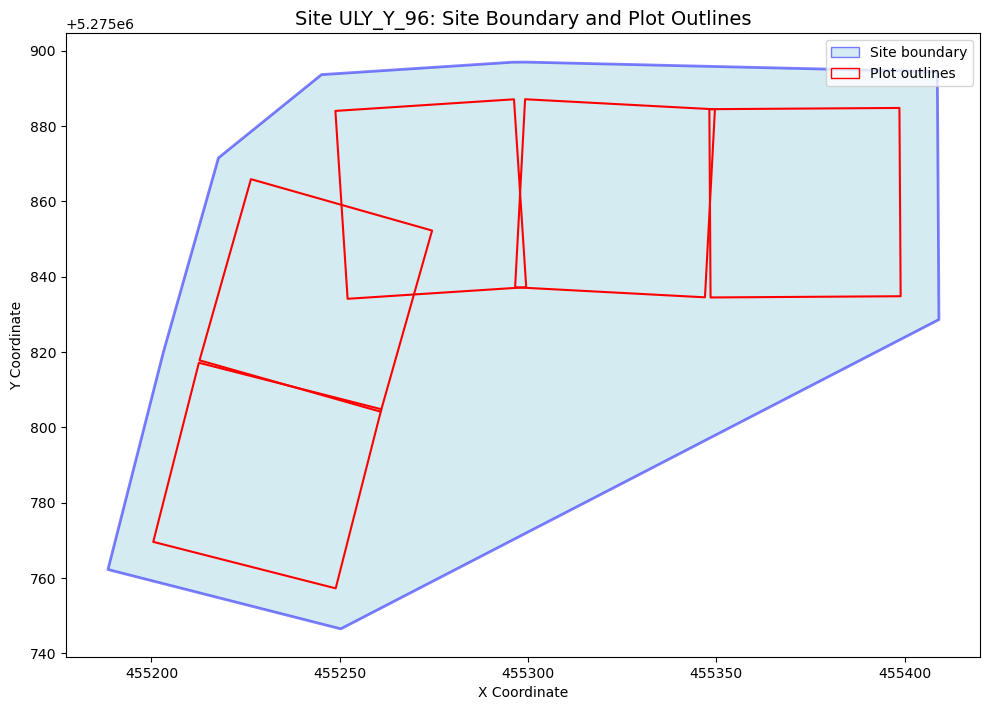

In [83]:
def plot_site_and_plots(site_name, sites_gdf, plots_gdf, figsize=(10, 8)):
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=figsize)
    
    # Filter data for the specified site
    site_data = sites_gdf[sites_gdf["site"] == site_name]
    plots_data = plots_gdf[plots_gdf["site"] == site_name]
    
    # Check if site exists
    if site_data.empty:
        print(f"Site '{site_name}' not found!")
        return
    
    # Plot the site boundary (filled with transparency)
    site_data.plot(ax=ax, color='lightblue', alpha=0.5, edgecolor='blue', linewidth=2)
    
    # Plot the plots as outlines only
    plots_data.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=1.5)
    
    # Create custom legend
    legend_elements = [
        Patch(facecolor='lightblue', alpha=0.5, edgecolor='blue', label='Site boundary'),
        Patch(facecolor='none', edgecolor='red', label='Plot outlines')
    ]
    ax.legend(handles=legend_elements)
    
    # Add labels and title
    ax.set_title(f'Site {site_name}: Site Boundary and Plot Outlines', fontsize=14)
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    
    # Make the plot look nice
    plt.tight_layout()
    plt.show()

for site in sites["site"].unique():
    plot_site_and_plots(site, sites, plots)
